# Regularização

Como vimos, redes neurais podem ser impactadas pelo fenômeno do sobre-ajuste. Nesta interação, abordaremos duas técnicas que buscam forçar redes neurais a criarem mapeamentos mais suaves: a regularização de parâmetros e a validação cruzada.

## Objetivos

Ao fim desta lição, o aluno será capaz de:

1. Projetar um parâmetro de regularização adequado a um problema de regressão
2. Planejar e executar um procedimento de treinamento baseado em validação cruzada

## Regularização

A *regularização* é um processo que busca penalizar determinadas configurações de sistemas que são claramente inadequados a um problema. Assim, além de minimizar o erro ($E = ||\boldsymbol y_e - \boldsymbol y||^2.$), o processo de treinamento também buscará minimizar uma determinada função do conjunto de parâmetros $\theta$ da rede. É comum que essa função seja a norma L1 ou L2 dos pesos da rede.

Numa rede regularizada, a função-objetivo, que deve ser minimizada, é dada por:
$$E + \lambda f(\theta),$$
onde $\lambda$ é um parâmetro que determina o quão regular a rede deverá ser. Se definirmos $f(\theta) = ||\theta||_1$, então a função de retro-propagação poderá ser re-definida, na forma: 

In [54]:
# Inicializacao
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

def nova_mlp(entradas, saidas, camadas):
    lista_de_camadas = [entradas] + camadas + [saidas]
    pesos = []
    for i in xrange(len(lista_de_camadas)-1):
        pesos.append(np.random.random((lista_de_camadas[i+1], lista_de_camadas[i])))
    return pesos

def ff_mlp(entradas, pesos):
    s = entradas
    for i in xrange(len(pesos)-1):
        s = np.tanh(np.dot(pesos[i],s))
    s = np.dot(pesos[-1],s)
    return s

def backpropagation_step(entradas, saidas, pesos, regular=0.01, passo=0.01):
    derivadas = []
    resultados_intermediarios = [entradas]
    s = entradas
    for i in xrange(len(pesos)-1):
        s = np.tanh(np.dot(pesos[i],s))
        resultados_intermediarios.append(s)
    s = np.dot(pesos[-1],s)
    resultados_intermediarios.append(s)
  
    # Derivada do erro em relacao a saida estimada
    dedye = (resultados_intermediarios[-1] - saidas)
    
    # Derivada em relacao a camada de saida linear
    dedb = np.dot(dedye, resultados_intermediarios[-2].T)
    
    # Para cada camada nao-linear, calcula a nova derivada na forma:
    deda = dedye

    for i in range(len(pesos)-2, -1, -1):
        linear = np.dot(pesos[i], resultados_intermediarios[i])
        flz = (1-np.tanh(linear)**2) 
        deda = np.dot(pesos[i+1].T, deda) # deriv_front
        derivada = np.dot(deda * flz, resultados_intermediarios[i].T)
        derivadas.insert (0, derivada)

    derivadas.append(dedb)
    
    # Executa um passo na direcao contraria da derivada e adiciona minimizacao da
    # norma L1 ponderada por lambda
    for i in xrange(len(derivadas)):
        n = np.linalg.norm(derivadas[i])
        pesos[i] -= passo * (derivadas[i]/n + (regular * np.sign(pesos[i])))
    
    return pesos

def erro(y, y_e):    
    return np.sum((y-y_e)**2)

 ## Resultados da regularização

A seguir, aplicaremos a regularização no mesmo problema de regressão de uma parábola abordado anteriormente:

EQM final: 29.9064396794


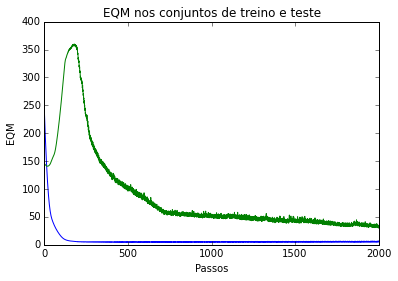

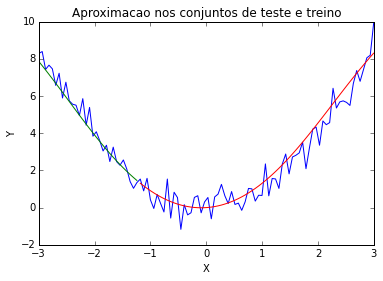

In [72]:
# Usando as 30 primeiras amostras (30% do total) para o aprendizado
x = np.linspace(-3, 3, num=100)
y_ = x**2
y = y_ + np.random.normal(0, 0.5, 100) # Criando uma parabola com ruido
x.shape = (1, x.size)
y.shape = (1, y.size)
x_treino = x[:,0:30]
x_teste = x[:,30:100]
y_treino = y[:,0:30]
y_teste = y[:,30:100]

x_treino2 = np.vstack((x_treino, x_treino**2))
x_teste2 = np.vstack((x_teste, x_teste**2))
mlp0 = nova_mlp(entradas=2, saidas=1, camadas=[10])

# Processo de treinamento
n_passos = 2000
eqm_treino = np.zeros((n_passos+1))
eqm_treino[0] = erro(y_treino, ff_mlp(x_treino2, mlp0))
eqm_teste = np.zeros((n_passos+1))
eqm_teste[0] = erro(y_teste, ff_mlp(x_teste2, mlp0))

for i in xrange(n_passos):
    mlp0 = backpropagation_step(x_treino2, y_treino, mlp0, regular=0.1)
    eqm_treino[i+1] = erro(y_treino, ff_mlp(x_treino2, mlp0))
    eqm_teste[i+1] = erro(y_teste, ff_mlp(x_teste2, mlp0))

print "EQM final:", eqm_teste[-1]
    
plt.figure();
plt.plot(range(n_passos+1), eqm_treino);
plt.plot(range(n_passos+1), eqm_teste);
plt.ylabel('EQM');
plt.xlabel('Passos');
plt.title('EQM nos conjuntos de treino e teste');

plt.figure();
plt.plot(x.T, y.T);
plt.plot(x_treino.T, ff_mlp(x_treino2, mlp0).T);
plt.plot(x_teste.T, ff_mlp(x_teste2, mlp0).T);
plt.ylabel('Y');
plt.xlabel('X');
plt.title('Aproximacao nos conjuntos de teste e treino');

Podemos verificar que o erro de teste, ao final das iterações, é significativamente menor que no caso do treinamento sem regularização.

Execute o código algumas vezes, variando o parâmetro de regularização, e verifique o que acontece com o EQM para regularizações muito fortes e muito fracas.

## Exercícios

1. Modifique o código fornecido para que a regularização seja executada sobre a norma L2, e não sobre a norma L1, da rede neural encontrada. Teste ambas as versões e discuta os problemas encontrados.

2. Qual é a relação entre a regularização e a capacidade de aproximação universal?

3. A norma L1 está ligada à *esparsidade* dos parâmetros da rede. Escreva um pequeno texto (de não mais que 500 palavras) discutindo o que significa esparsidade e porque ela é importante.

4. Utilize a rede neural regularizada num problema de classificação ou de regressão à sua escolha. Durante esse procedimento, investigue o impacto da regularização no problema em questão, variando $\lambda$. 